<h1><b> Kto wygra mecz?

In [622]:
# import sys
# !{sys.executable} -m pip install sqlite3

* Najpierw pobieramy pakiet sqlite3, aby moć przekształcić nasze dane z formatu sqlite do standardowego DataFrame

In [623]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

countries_dataframe = pd.read_sql('SELECT * from Country', conn)
leaugues_dataframe = pd.read_sql('SELECT * from League', conn)
matches_dataframe = pd.read_sql('SELECT * from Match', conn)
players_dataframe = pd.read_sql('SELECT * from Player', conn)
player_attributes_dataframe = pd.read_sql('SELECT * from Player_Attributes', conn)
teams_dataframe = pd.read_sql('SELECT * from Team', conn)
team_attributes_dataframe = pd.read_sql('SELECT * from Team_Attributes', conn)

* Najważniejsze będzie dla nas będzie matches_dataframe, ponieważ postaramy się przewidzieć wyniki meczy.
<br> <br>
* Użyjemy również danych z team_attributes_dataframe, które zawierają statystyki pochodzące z różnych wydań serii gier komputerowych FIFA
<br> <br>
* Nasz zbiór danych zawiera wiele danych w 115 kolumnach, ale jednak nie wszystkie użyjemy, ponieważ część zawiera informacje, których jesteśmy mieć przed meczem (takich jak posiadanie piłki itp., typy rożnych znanych bukmacherów, a i również składy obu drużyn - oczywiście bukmacherzy oferują możliwość obstawiania meczu tuż przed samym meczem, ale mi się skupimy na spróbowaniu odgadnięcia wyniku z większym wyprzedzeniem).

In [624]:
print(len(matches_dataframe.columns))
matches_dataframe.head()

115


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


* Nasze dane pochodzą z sezonów 08/09 aż do (początku) 15/16, pierwszy mecz pochodzi z dnia 2008-08-17, a ostatni z 2015-09-23
* Będziemy rozważać 11 najsilniejszych lig w Europie (chociaż obecność tutaj Ekstraklasy jest wątpliwa)
<br><br>
* Posortujemy też od razu nasze mecze wg daty

In [625]:
from IPython.display import display, HTML

print(matches_dataframe.season.unique())
print(leaugues_dataframe.name.unique())
print(countries_dataframe.name.unique())

def split_date(x):
    return x.split()[0]

matches_dataframe.date = matches_dataframe["date"].apply(split_date) # usuwamy zbedna godzine w dacie
team_attributes_dataframe.date = team_attributes_dataframe["date"].apply(split_date) # usuwamy zbedna godzine w dacie

matches_dataframe = matches_dataframe.sort_values(by="date")
print("\n\nDane począwszy od", matches_dataframe.date.iloc[0].split()[0], "aż do", matches_dataframe.date.iloc[-1].split()[0])


['2008/2009' '2009/2010' '2010/2011' '2011/2012' '2012/2013' '2013/2014'
 '2014/2015' '2015/2016']
['Belgium Jupiler League' 'England Premier League' 'France Ligue 1'
 'Germany 1. Bundesliga' 'Italy Serie A' 'Netherlands Eredivisie'
 'Poland Ekstraklasa' 'Portugal Liga ZON Sagres' 'Scotland Premier League'
 'Spain LIGA BBVA' 'Switzerland Super League']
['Belgium' 'England' 'France' 'Germany' 'Italy' 'Netherlands' 'Poland'
 'Portugal' 'Scotland' 'Spain' 'Switzerland']


Dane począwszy od 2008-07-18 aż do 2016-05-25


* Niepotrzebne dla naszego zadania, ale warto zobaczyć 10 najlepszych (wg gry FIFA) piłkarzy i ich oceny

In [626]:
sorted_players_by_ovr = player_attributes_dataframe.sort_values(by="overall_rating")
sorted_players_by_ovr = sorted_players_by_ovr[sorted_players_by_ovr['overall_rating'].notna()]
sorted_players_by_ovr = sorted_players_by_ovr.tail(45)
sorted_players_by_ovr = sorted_players_by_ovr.drop_duplicates(subset=["player_api_id"], keep='last')

for i in range(0,10):
    print(sorted_players_by_ovr.iloc[i]["overall_rating"], players_dataframe.loc[players_dataframe["player_api_id"] == sorted_players_by_ovr.iloc[i]["player_api_id"], ("player_name")].values[0] )

91.0 Thierry Henry
91.0 Fabio Cannavaro
91.0 Alessandro Nesta
91.0 Andres Iniesta
92.0 Xavi Hernandez
92.0 Gregory Coupet
93.0 Gianluigi Buffon
93.0 Wayne Rooney
93.0 Cristiano Ronaldo
94.0 Lionel Messi


<h3> Właściwy zbiór danych </h3>

* Usuniemy teraz zbędne kolumny w matches_dataframe (wybierzemy tylko te, które chcemy)

In [627]:
df_towork = matches_dataframe[["country_id","league_id","season","stage", "date","match_api_id","home_team_api_id","away_team_api_id","home_team_goal","away_team_goal"]]
df_towork = df_towork.reset_index()
df_towork.drop('index', inplace=True, axis=1)
df_towork

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,24558,24558,2008/2009,1,2008-07-18,486263,10192,9931,1,2
1,24558,24558,2008/2009,1,2008-07-19,486264,9930,10179,3,1
2,24558,24558,2008/2009,1,2008-07-20,486265,10199,9824,1,2
3,24558,24558,2008/2009,1,2008-07-20,486266,7955,10243,1,2
4,24558,24558,2008/2009,2,2008-07-23,486268,6493,7955,1,2
...,...,...,...,...,...,...,...,...,...,...
25974,24558,24558,2015/2016,36,2016-05-25,1992225,9931,9956,0,1
25975,24558,24558,2015/2016,36,2016-05-25,1992226,7896,10190,3,0
25976,24558,24558,2015/2016,36,2016-05-25,1992227,10199,10179,2,2
25977,24558,24558,2015/2016,36,2016-05-25,1992228,10191,10192,0,3


* Zamienimy teraz id poszczególnych lig na ich nazwy - dla przejrzystości

In [628]:
# for i in range(len(leaugues_dataframe)):
#     print(leaugues_dataframe.loc[i,("country_id")], " : '", leaugues_dataframe.loc[i,("name")], "', ", end="", sep="")
# leaugues_dataframe
dictionary = {1 : 'Belgium Jupiler League', 1729 : 'England Premier League', 4769 : 'France Ligue 1', 7809 : 'Germany 1. Bundesliga', 10257 : 'Italy Serie A', 13274 : 'Netherlands Eredivisie', 15722 : 'Poland Ekstraklasa', 17642 : 'Portugal Liga ZON Sagres', 19694 : 'Scotland Premier League', 21518 : 'Spain LIGA BBVA', 24558 : 'Switzerland Super League'}
df_towork.replace({"league_id": dictionary}, inplace=True)
df_towork.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,24558,Switzerland Super League,2008/2009,1,2008-07-18,486263,10192,9931,1,2
1,24558,Switzerland Super League,2008/2009,1,2008-07-19,486264,9930,10179,3,1
2,24558,Switzerland Super League,2008/2009,1,2008-07-20,486265,10199,9824,1,2
3,24558,Switzerland Super League,2008/2009,1,2008-07-20,486266,7955,10243,1,2
4,24558,Switzerland Super League,2008/2009,2,2008-07-23,486268,6493,7955,1,2


* Teraz będziemy chcieli w jakiś sposób móc użyć do przewidawania wyniku wyników poprzedzających ten mecz. Więc najpierw wydobędziemy historie meczy dla każdej drużyny 
(i potem będziemy używać to tak, że będziemy patrzeć ile meczy dana drużyna już zagrała i wtedy będziemy wiedziali od którego momentu w historii meczy będziemy musieli zacząć)

* Każdy mecz w historii meczy jest zapisany jako krotka: $(a,b,c)$ gdzie:
<br>$a=0$ jeśli drużyna przegrała, $a=1$ jeśli drużyna wygrała, $a=2$ jeśli drużyna zremisowała
<br>$b$ - ilość goli strzelonych
<br>$c$ - ilość goli straconych

In [629]:
import numpy as np
df_towork["nr_of_prev_home_occurences"] = np.zeros(len(df_towork))
df_towork["nr_of_prev_away_occurences"] = np.zeros(len(df_towork))

teams_dataframe["occurences"] = np.zeros(len(teams_dataframe))
teams_dataframe["history_of_team_matches"]  = [list() for x in range(len(teams_dataframe.index))]    # (kto_wygral, gole_strzelone, gole_stracone) , kto wygral: 0-druzyna przegrala, 1-wygrala, 2-zremisowala

for i in range(len(df_towork)):
    df_towork.loc[i,("nr_of_prev_home_occurences")] = teams_dataframe.loc[teams_dataframe["team_api_id"]==df_towork.iloc[i]["home_team_api_id"], ('occurences')].values[0]
    df_towork.loc[i,("nr_of_prev_away_occurences")] = teams_dataframe.loc[teams_dataframe["team_api_id"]==df_towork.iloc[i]["away_team_api_id"], ('occurences')].values[0]
    teams_dataframe.loc[teams_dataframe["team_api_id"]==df_towork.iloc[i]["home_team_api_id"], ('occurences')] +=1
    teams_dataframe.loc[teams_dataframe["team_api_id"]==df_towork.iloc[i]["away_team_api_id"], ('occurences')] +=1

    h_goals = df_towork.iloc[i]["home_team_goal"]
    a_goals = df_towork.iloc[i]["away_team_goal"]
    res_for_home = (1 if h_goals>a_goals else 0 if a_goals>h_goals else 2,h_goals,a_goals)
    res_for_away = (1 if h_goals<a_goals else 0 if a_goals<h_goals else 2,a_goals,h_goals)

    teams_dataframe.loc[teams_dataframe["team_api_id"]==df_towork.iloc[i]["home_team_api_id"], ('history_of_team_matches')].values[0].append( res_for_home )
    teams_dataframe.loc[teams_dataframe["team_api_id"]==df_towork.iloc[i]["away_team_api_id"], ('history_of_team_matches')].values[0].append( res_for_away )

In [630]:
teams_dataframe.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,occurences,history_of_team_matches
0,1,9987,673.0,KRC Genk,GEN,212.0,"[(2, 1, 1), (0, 1, 3), (1, 1, 0), (1, 3, 1), (..."
1,2,9993,675.0,Beerschot AC,BAC,152.0,"[(2, 1, 1), (2, 1, 1), (0, 0, 1), (1, 3, 0), (..."
2,3,10000,15005.0,SV Zulte-Waregem,ZUL,212.0,"[(2, 0, 0), (1, 2, 0), (0, 1, 3), (0, 0, 2), (..."
3,4,9994,2007.0,Sporting Lokeren,LOK,212.0,"[(2, 0, 0), (1, 4, 1), (0, 0, 1), (2, 1, 1), (..."
4,5,9984,1750.0,KSV Cercle Brugge,CEB,182.0,"[(0, 0, 3), (0, 1, 2), (1, 2, 1), (0, 2, 3), (..."


* Teraz dodamy do matches_dataframe, do każdego meczu kolumny z informacjami o ilości wygranych / przegranych / remisów gospodarza / gościa ostatnich 5 i 10 meczach, jak i również informację o ilości strzelonych / straconych bramek przez gospodarza / gościa

* Ważne: jeśli "brakuje" meczy w historii tzn. nie było przed danym meczem 5 lub 10 meczy danej drużyny to wynik i ilości zdobytych / straconych bramek są wylosowywane

In [631]:
df_towork["nr_of_prev_home_occurences"] = df_towork["nr_of_prev_home_occurences"].apply(int)
df_towork["nr_of_prev_away_occurences"] = df_towork["nr_of_prev_away_occurences"].apply(int)

df_towork["last5_home_wins"] = np.zeros(len(df_towork))
df_towork["last5_home_draws"] = np.zeros(len(df_towork))
df_towork["last5_home_defeats"] = np.zeros(len(df_towork))
df_towork["last5_away_wins"] = np.zeros(len(df_towork))
df_towork["last5_away_draws"] = np.zeros(len(df_towork))
df_towork["last5_away_defeats"] = np.zeros(len(df_towork))

df_towork["last5_home_goals_scored"] = np.zeros(len(df_towork))
df_towork["last5_away_goals_scored"] = np.zeros(len(df_towork))
df_towork["last5_home_goals_conceded"] = np.zeros(len(df_towork))
df_towork["last5_away_goals_conceded"] = np.zeros(len(df_towork))

#######################
df_towork["last10_home_wins"] = np.zeros(len(df_towork))
df_towork["last10_home_draws"] = np.zeros(len(df_towork))
df_towork["last10_home_defeats"] = np.zeros(len(df_towork))
df_towork["last10_away_wins"] = np.zeros(len(df_towork))
df_towork["last10_away_draws"] = np.zeros(len(df_towork))
df_towork["last10_away_defeats"] = np.zeros(len(df_towork))

df_towork["last10_home_goals_scored"] = np.zeros(len(df_towork))
df_towork["last10_away_goals_scored"] = np.zeros(len(df_towork))
df_towork["last10_home_goals_conceded"] = np.zeros(len(df_towork))
df_towork["last10_away_goals_conceded"] = np.zeros(len(df_towork))
#######################

for i in range(len(df_towork)):
    his_home = teams_dataframe.loc[teams_dataframe["team_api_id"]==df_towork.iloc[i]["home_team_api_id"], ('history_of_team_matches')].values[0]
    his_away = teams_dataframe.loc[teams_dataframe["team_api_id"]==df_towork.iloc[i]["away_team_api_id"], ('history_of_team_matches')].values[0]
    prev_home = df_towork.loc[i,("nr_of_prev_home_occurences")]
    prev_away = df_towork.loc[i,("nr_of_prev_away_occurences")]

    ######################
    his_home10 = his_home[max(0,prev_home-10):prev_home]
    if len(his_home10)<10:
        for j in range(10-len(his_home10)):
            his_home10.append(np.random.randint(low=0,high=3,size=3))
    his_away10 = his_away[max(0,prev_away-10):prev_away]
    if len(his_away10)<10:
        for j in range(10-len(his_away10)):
            his_away10.append(np.random.randint(low=0,high=3,size=3))

    df_towork.loc[i,"last10_home_goals_scored"] = sum([i for i in [arr[1] for arr in his_home10]])
    df_towork.loc[i,"last10_away_goals_scored"] = sum([i for i in [arr[1] for arr in his_away10]])
    df_towork.loc[i,"last10_home_goals_conceded"] = sum([i for i in [arr[2] for arr in his_home10]])
    df_towork.loc[i,"last10_away_goals_conceded"] = sum([i for i in [arr[2] for arr in his_away10]])

    df_towork.loc[i,"last10_home_defeats"] = len([i for i in [arr[0] for arr in his_home10] if i==0])
    df_towork.loc[i,"last10_away_defeats"] = len([i for i in [arr[0] for arr in his_away10] if i==0])
    df_towork.loc[i,"last10_home_wins"] = len([i for i in [arr[0] for arr in his_home10] if i==1])
    df_towork.loc[i,"last10_away_wins"] = len([i for i in [arr[0] for arr in his_away10] if i==1])
    df_towork.loc[i,"last10_home_draws"] = len([i for i in [arr[0] for arr in his_home10] if i==2])
    df_towork.loc[i,"last10_away_draws"] = len([i for i in [arr[0] for arr in his_away10] if i==2])


    #######################

    his_home = his_home[max(0,prev_home-5):prev_home]
    if len(his_home)<5:
        for j in range(5-len(his_home)):
            his_home.append(np.random.randint(low=0,high=3,size=3))
    his_away = his_away[max(0,prev_away-5):prev_away]
    if len(his_away)<5:
        for j in range(5-len(his_away)):
            his_away.append(np.random.randint(low=0,high=3,size=3))

    df_towork.loc[i,"last5_home_goals_scored"] = sum([i for i in [arr[1] for arr in his_home]])
    df_towork.loc[i,"last5_away_goals_scored"] = sum([i for i in [arr[1] for arr in his_away]])
    df_towork.loc[i,"last5_home_goals_conceded"] = sum([i for i in [arr[2] for arr in his_home]])
    df_towork.loc[i,"last5_away_goals_conceded"] = sum([i for i in [arr[2] for arr in his_away]])

    df_towork.loc[i,"last5_home_defeats"] = len([i for i in [arr[0] for arr in his_home] if i==0])
    df_towork.loc[i,"last5_away_defeats"] = len([i for i in [arr[0] for arr in his_away] if i==0])
    df_towork.loc[i,"last5_home_wins"] = len([i for i in [arr[0] for arr in his_home] if i==1])
    df_towork.loc[i,"last5_away_wins"] = len([i for i in [arr[0] for arr in his_away] if i==1])
    df_towork.loc[i,"last5_home_draws"] = len([i for i in [arr[0] for arr in his_home] if i==2])
    df_towork.loc[i,"last5_away_draws"] = len([i for i in [arr[0] for arr in his_away] if i==2])

In [632]:
df_towork.tail()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,last10_home_wins,last10_home_draws,last10_home_defeats,last10_away_wins,last10_away_draws,last10_away_defeats,last10_home_goals_scored,last10_away_goals_scored,last10_home_goals_conceded,last10_away_goals_conceded
25974,24558,Switzerland Super League,2015/2016,36,2016-05-25,1992225,9931,9956,0,1,...,6.0,3.0,1.0,2.0,3.0,5.0,25.0,9.0,13.0,13.0
25975,24558,Switzerland Super League,2015/2016,36,2016-05-25,1992226,7896,10190,3,0,...,2.0,2.0,6.0,2.0,2.0,6.0,10.0,11.0,23.0,26.0
25976,24558,Switzerland Super League,2015/2016,36,2016-05-25,1992227,10199,10179,2,2,...,7.0,2.0,1.0,4.0,3.0,3.0,26.0,15.0,8.0,14.0
25977,24558,Switzerland Super League,2015/2016,36,2016-05-25,1992228,10191,10192,0,3,...,2.0,5.0,3.0,7.0,0.0,3.0,14.0,29.0,14.0,16.0
25978,24558,Switzerland Super League,2015/2016,36,2016-05-25,1992229,10243,9824,3,1,...,1.0,3.0,6.0,4.0,3.0,3.0,11.0,18.0,23.0,16.0


* Teraz postaramy się coś wydobyć ze statystyk zespołów (z gry FIFA) 

* Tworze DataFrame ze statystykami zespołów: fifa_statistics

In [633]:
fifa_statistics = pd.DataFrame(team_attributes_dataframe)
fifa_statistics.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


* Problem z NaNami mamy tylko w kolumnie "buildUpPlayDribbling"

In [634]:
list_of_nans = []
for i in range(21):
    list_of_nans.append(fifa_statistics.iloc[:,i].isnull().sum())
print(list_of_nans)
print("\nWartości statystyki \"buildUpPlayDribbling\"",fifa_statistics.iloc[:,6].unique())

[0, 0, 0, 0, 0, 0, 969, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Wartości statystyki "buildUpPlayDribbling" [nan 48. 41. 64. 57. 70. 53. 47. 40. 43. 46. 61. 49. 66. 51. 32. 37. 45.
 52. 50. 38. 55. 35. 63. 30. 29. 34. 24. 39. 31. 60. 44. 36. 56. 54. 33.
 59. 58. 42. 69. 62. 67. 65. 77. 28. 68. 71. 26. 27. 74.]


* Uzupełniam brakujące wartości medianą z reszty wartości tej statystyki

In [635]:
median = np.nanmedian(fifa_statistics["buildUpPlayDribbling"])
fifa_statistics["buildUpPlayDribbling"] = fifa_statistics["buildUpPlayDribbling"].fillna(median)
print(median)

49.0


* Teraz przekształcimy rożne statystyki liczbowe do zbiorczych statystyk: atak / pomoc / obrona
<br><br>
* Możemy tak dodać do siebie różne statystyki, bo wszystkie statystyki są z przedziału od 0 do 100

In [636]:
print(list(fifa_statistics))

['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass', 'buildUpPlayDribbling', 'buildUpPlayDribblingClass', 'buildUpPlayPassing', 'buildUpPlayPassingClass', 'buildUpPlayPositioningClass', 'chanceCreationPassing', 'chanceCreationPassingClass', 'chanceCreationCrossing', 'chanceCreationCrossingClass', 'chanceCreationShooting', 'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressure', 'defencePressureClass', 'defenceAggression', 'defenceAggressionClass', 'defenceTeamWidth', 'defenceTeamWidthClass', 'defenceDefenderLineClass']


In [637]:
fifa_statistics["attacking_stats"] = np.zeros(len(fifa_statistics))
fifa_statistics["midfield_stats"] = np.zeros(len(fifa_statistics))
fifa_statistics["defensive_stats"] = np.zeros(len(fifa_statistics))

for i in range(len(fifa_statistics)):
    fifa_statistics.loc[i,("attacking_stats")] = sum(fifa_statistics.loc[i, ['chanceCreationShooting',"buildUpPlaySpeed","buildUpPlayDribbling"]])
    fifa_statistics.loc[i,("midfield_stats")] = sum(fifa_statistics.loc[i, ["chanceCreationPassing","buildUpPlayPassing",'chanceCreationPassing','chanceCreationCrossing']])
    fifa_statistics.loc[i,("defensive_stats")] = sum(fifa_statistics.loc[i, ["defenceAggression",'defencePressure']])
fifa_statistics.drop(['chanceCreationShooting',"buildUpPlaySpeed","buildUpPlayDribbling","chanceCreationPassing","buildUpPlayPassing",'chanceCreationPassing','chanceCreationCrossing',"defenceAggression",'defencePressure',"defenceTeamWidth"], axis = 1, inplace=True)

* Mamy rownież informacje kategoryczne o stylach gry w wielu aspektach, ale zostawie tylko istotne
<br><br>
* Dodam także na końcu wiersz (z najczęstszymi wartościami) z którego będą korzystać zespoły, które nie mają statystyk w FIFIE albo nie ma ich przed datą rozegranego meczu

In [638]:
# zostawie tylko kluczowe style gry
fifa_statistics = fifa_statistics[['id','team_api_id', 'date','buildUpPlayPositioningClass','chanceCreationPositioningClass','defencePressureClass','defenceTeamWidthClass', 'attacking_stats', 'midfield_stats', 'defensive_stats']]

mylist = list(fifa_statistics)
mylist = mylist[3:]

for i in mylist[:4]:
    print(i," : ", fifa_statistics[i].mode().values[0])     # najczęstrze wartości dla danych kategorycznych
for i in mylist[4:]:
    print(i," : ", fifa_statistics[i].median())             # mediana wartości dla danych numerycznych

new_row = {
    'id':len(fifa_statistics)+1, 'team_api_id':0, 'date':"2000-01-01",
    'buildUpPlayPositioningClass': 'Organised', 
    'chanceCreationPositioningClass': 'Organised',
    'defencePressureClass' :  'Medium',
    'defenceTeamWidthClass'  :  'Normal',
    'attacking_stats'  :  154.0,
    'midfield_stats'  :  206.0,
    'defensive_stats'  :  93.0,
    }

fifa_statistics = fifa_statistics.append(new_row, ignore_index=True);
fifa_statistics.tail()

buildUpPlayPositioningClass  :  Organised
chanceCreationPositioningClass  :  Organised
defencePressureClass  :  Medium
defenceTeamWidthClass  :  Normal
attacking_stats  :  154.0
midfield_stats  :  206.0
defensive_stats  :  93.0


,id,team_api_id,date,buildUpPlayPositioningClass,chanceCreationPositioningClass,defencePressureClass,defenceTeamWidthClass,attacking_stats,midfield_stats,defensive_stats
1454,1455,10000,2012-02-22,Organised,Organised,Medium,Normal,153.0,197.0,99.0
1455,1456,10000,2013-09-20,Organised,Organised,Medium,Normal,135.0,197.0,102.0
1456,1457,10000,2014-09-19,Organised,Organised,Medium,Normal,128.0,197.0,102.0
1457,1458,10000,2015-09-10,Organised,Organised,Medium,Normal,128.0,197.0,102.0
1458,1459,0,2000-01-01,Organised,Organised,Medium,Normal,154.0,206.0,93.0


* Teraz dodamy statystyki z fifa_statistics do każdego meczu tzn. przy każdym meczu będą znajdować się statystyki gospodarza i gości

In [639]:
len_df_work = len(df_towork)
len_fifa = len(fifa_statistics)

df_towork['home_attacking_stats'] = np.zeros(len_df_work)
df_towork['home_midfield_stats'] = np.zeros(len_df_work)
df_towork['home_defensive_stats'] = np.zeros(len_df_work)
df_towork['away_attacking_stats'] = np.zeros(len_df_work)
df_towork['away_midfield_stats'] = np.zeros(len_df_work)
df_towork['away_defensive_stats'] = np.zeros(len_df_work)

df_towork['home_ppc'] = ['']*len_df_work
df_towork['home_cpc'] = ['']*len_df_work
df_towork['home_dpc'] = ['']*len_df_work
df_towork['home_twc'] = ['']*len_df_work
df_towork['away_ppc'] = ['']*len_df_work
df_towork['away_cpc'] = ['']*len_df_work
df_towork['away_dpc'] = ['']*len_df_work
df_towork['away_twc'] = ['']*len_df_work

for i in range(len(df_towork)):
    fifa_dates_home = list(fifa_statistics.loc[fifa_statistics["team_api_id"]==df_towork.iloc[i]["home_team_api_id"],("date")])
    fifa_dates_away = list(fifa_statistics.loc[fifa_statistics["team_api_id"]==df_towork.iloc[i]["away_team_api_id"],("date")])
    match_date = df_towork.iloc[i]["date"]

    day_of_stats_home = ""
    day_of_stats_away = ""

    if len(fifa_dates_home)!=0:
        dates_home = [j for j in fifa_dates_home if j<match_date]
        day_of_stats_home = max(dates_home) if len(dates_home)!=0 else fifa_dates_home[0]
        df_towork.loc[i,("home_attacking_stats")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["home_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_home)),("attacking_stats") ].values[0]
        df_towork.loc[i,("home_midfield_stats")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["home_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_home)),("midfield_stats") ].values[0]
        df_towork.loc[i,("home_defensive_stats")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["home_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_home)),("defensive_stats") ].values[0]
        
        df_towork.loc[i,("home_ppc")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["home_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_home)),("buildUpPlayPositioningClass") ].values[0]
        df_towork.loc[i,("home_cpc")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["home_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_home)),("chanceCreationPositioningClass") ].values[0]
        df_towork.loc[i,("home_dpc")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["home_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_home)),("defencePressureClass") ].values[0]
        df_towork.loc[i,("home_twc")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["home_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_home)),("defenceTeamWidthClass") ].values[0]
    else:
        df_towork.loc[i,("home_attacking_stats")] = fifa_statistics.loc[ len_fifa-1,("attacking_stats") ]
        df_towork.loc[i,("home_midfield_stats")] = fifa_statistics.loc[ len_fifa-1,("midfield_stats") ]
        df_towork.loc[i,("home_defensive_stats")] = fifa_statistics.loc[ len_fifa-1,("defensive_stats") ]

        df_towork.loc[i,("home_ppc")] = fifa_statistics.loc[ len_fifa-1,("buildUpPlayPositioningClass") ]
        df_towork.loc[i,("home_cpc")] = fifa_statistics.loc[ len_fifa-1,("chanceCreationPositioningClass") ]
        df_towork.loc[i,("home_dpc")] = fifa_statistics.loc[ len_fifa-1,("defencePressureClass") ]
        df_towork.loc[i,("home_twc")] = fifa_statistics.loc[ len_fifa-1,("defenceTeamWidthClass") ]
  
    if len(fifa_dates_away)!=0:
        dates_away = [j for j in fifa_dates_away if j<match_date]
        day_of_stats_away = max(dates_away) if len(dates_away)!=0 else fifa_dates_away[0]
        df_towork.loc[i,("away_attacking_stats")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["away_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_away)),("attacking_stats") ].values[0]
        df_towork.loc[i,("away_midfield_stats")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["away_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_away)),("midfield_stats") ].values[0]
        df_towork.loc[i,("away_defensive_stats")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["away_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_away)),("defensive_stats") ].values[0]
    
        df_towork.loc[i,("away_ppc")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["away_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_away)),("buildUpPlayPositioningClass") ].values[0]
        df_towork.loc[i,("away_cpc")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["away_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_away)),("chanceCreationPositioningClass") ].values[0]
        df_towork.loc[i,("away_dpc")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["away_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_away)),("defencePressureClass") ].values[0]
        df_towork.loc[i,("away_twc")] = fifa_statistics.loc[ ((fifa_statistics["team_api_id"]==df_towork.iloc[i]["away_team_api_id"]) & (fifa_statistics["date"]==day_of_stats_away)),("defenceTeamWidthClass") ].values[0]
    else:
        df_towork.loc[i,("away_attacking_stats")] = fifa_statistics.loc[ len_fifa-1,("attacking_stats") ]
        df_towork.loc[i,("away_midfield_stats")] = fifa_statistics.loc[ len_fifa-1,("midfield_stats") ]
        df_towork.loc[i,("away_defensive_stats")] = fifa_statistics.loc[ len_fifa-1,("defensive_stats") ]

        df_towork.loc[i,("away_ppc")] = fifa_statistics.loc[ len_fifa-1,("buildUpPlayPositioningClass") ]
        df_towork.loc[i,("away_cpc")] = fifa_statistics.loc[ len_fifa-1,("chanceCreationPositioningClass") ]
        df_towork.loc[i,("away_dpc")] = fifa_statistics.loc[ len_fifa-1,("defencePressureClass") ]
        df_towork.loc[i,("away_twc")] = fifa_statistics.loc[ len_fifa-1,("defenceTeamWidthClass") ]



In [640]:
df_towork['year'] = np.zeros(len(df_towork))
df_towork['month'] = np.zeros(len(df_towork))
df_towork['day'] = np.zeros(len(df_towork))
for i in range(len(df_towork)):
    date = df_towork.loc[i, ("date") ].split('-')
    df_towork.loc[i,("year")] = int(date[0])
    df_towork.loc[i,("month")] = int(date[1])
    df_towork.loc[i,("day")] = int(date[2])

<h3><b> Ostateczny zbiór danych podstawie, którego będziemy przewidywać wynik meczu

In [641]:
print(list(df_towork))
final_df = df_towork.drop(['date','country_id','match_api_id', 'home_team_goal', 'away_team_goal', 'nr_of_prev_home_occurences', 'nr_of_prev_away_occurences',], axis = 1)
print("\n\n",list(final_df))

['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'nr_of_prev_home_occurences', 'nr_of_prev_away_occurences', 'last5_home_wins', 'last5_home_draws', 'last5_home_defeats', 'last5_away_wins', 'last5_away_draws', 'last5_away_defeats', 'last5_home_goals_scored', 'last5_away_goals_scored', 'last5_home_goals_conceded', 'last5_away_goals_conceded', 'last10_home_wins', 'last10_home_draws', 'last10_home_defeats', 'last10_away_wins', 'last10_away_draws', 'last10_away_defeats', 'last10_home_goals_scored', 'last10_away_goals_scored', 'last10_home_goals_conceded', 'last10_away_goals_conceded', 'home_attacking_stats', 'home_midfield_stats', 'home_defensive_stats', 'away_attacking_stats', 'away_midfield_stats', 'away_defensive_stats', 'home_ppc', 'home_cpc', 'home_dpc', 'home_twc', 'away_ppc', 'away_cpc', 'away_dpc', 'away_twc', 'year', 'month', 'day']


 ['league_id', 'season', 'stage', 'home_team_api_id

In [642]:
final_df = pd.get_dummies(final_df,columns=['league_id','season','home_ppc', 'home_cpc', 'home_dpc', 'home_twc', 'away_ppc', 'away_cpc', 'away_dpc', 'away_twc'])
final_df.head()

,stage,home_team_api_id,away_team_api_id,last5_home_wins,last5_home_draws,last5_home_defeats,last5_away_wins,last5_away_draws,last5_away_defeats,last5_home_goals_scored,...,away_ppc_Free Form,away_ppc_Organised,away_cpc_Free Form,away_cpc_Organised,away_dpc_Deep,away_dpc_High,away_dpc_Medium,away_twc_Narrow,away_twc_Normal,away_twc_Wide
0,1,10192,9931,2.0,2.0,1.0,2.0,1.0,2.0,6.0,...,0,1,0,1,0,0,1,0,1,0
1,1,9930,10179,3.0,1.0,1.0,1.0,3.0,1.0,2.0,...,0,1,0,1,0,0,1,0,1,0
2,1,10199,9824,2.0,1.0,2.0,0.0,3.0,2.0,5.0,...,0,1,0,1,0,0,1,0,1,0
3,1,7955,10243,2.0,1.0,2.0,0.0,3.0,2.0,5.0,...,0,1,0,1,0,0,1,0,1,0
4,2,6493,7955,1.0,4.0,0.0,1.0,1.0,3.0,6.0,...,0,1,0,1,0,0,1,0,1,0


* Przegląd danych

Poza oczywistymi korelacjami (np. jak ilość wygranych meczy w ostatnich 5 meczach do wygranych w ostatnich 10), widać także zależność pomiędzy ocenami zespołów co wynika z pewnością z faktu, że silniejsze zespoły grają w ligach ze silniejszymi zespołami.

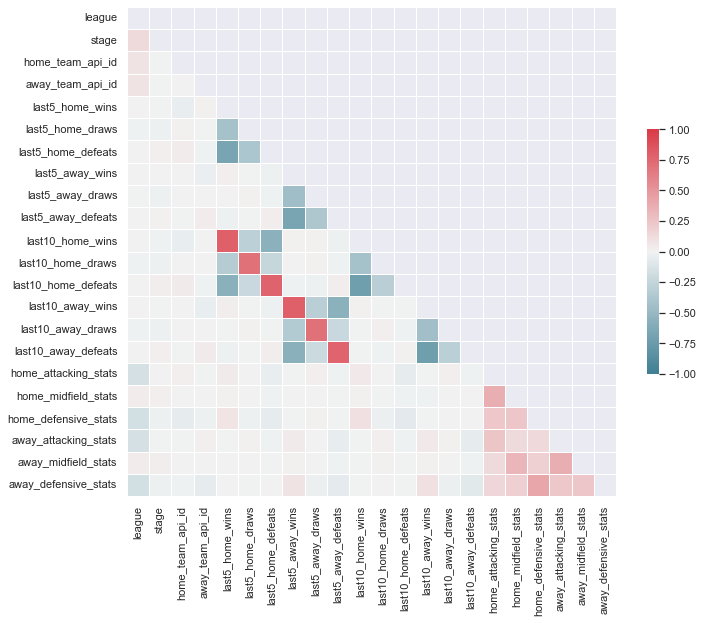

,league,stage,home_team_api_id,away_team_api_id,last5_home_wins,last5_home_draws,last5_home_defeats,last5_away_wins,last5_away_draws,last5_away_defeats,...,last10_home_defeats,last10_away_wins,last10_away_draws,last10_away_defeats,home_attacking_stats,home_midfield_stats,home_defensive_stats,away_attacking_stats,away_midfield_stats,away_defensive_stats
league,1.000000,0.131000,0.081943,0.082777,0.004219,-0.007868,0.002206,0.000286,-0.005442,0.004240,...,0.003810,0.003843,-0.014549,0.007108,-0.153007,0.031365,-0.165985,-0.153188,0.031744,-0.166391
stage,0.131000,1.000000,-0.006577,-0.003769,-0.003718,-0.019633,0.020027,0.002557,-0.020144,0.014135,...,0.024424,-0.006816,-0.019357,0.022125,0.000880,0.023051,-0.016518,-0.001000,0.025128,-0.019203
home_team_api_id,0.081943,-0.006577,1.000000,0.005653,-0.039774,0.008074,0.033869,0.003478,0.002805,-0.005954,...,0.042708,0.003848,0.003224,-0.006566,0.018869,0.004762,-0.054835,-0.003316,0.007013,-0.014230
away_team_api_id,0.082777,-0.003769,0.005653,1.000000,0.008957,-0.000162,-0.008997,-0.034986,0.000634,0.035839,...,-0.010154,-0.044319,0.002670,0.045014,-0.007271,0.003459,-0.016871,0.019182,0.004989,-0.054980
last5_home_wins,0.004219,-0.003718,-0.039774,0.008957,1.000000,-0.428902,-0.664737,0.021626,0.000562,-0.022947,...,-0.577172,0.024730,-0.005867,-0.021752,0.040669,0.007856,0.077150,-0.004526,0.001100,0.000271
last5_home_draws,-0.007868,-0.019633,0.008074,-0.000162,-0.428902,1.000000,-0.389767,-0.003611,0.012940,-0.007035,...,-0.224046,-0.003164,0.008649,-0.003291,0.005170,0.002185,-0.020308,0.015050,0.007427,-0.001298
last5_home_defeats,0.002206,0.020027,0.033869,-0.008997,-0.664737,-0.389767,1.000000,-0.019060,-0.011274,0.029211,...,0.773681,-0.022595,-0.001171,0.024897,-0.045735,-0.009816,-0.061855,-0.007833,-0.007263,0.000797
last5_away_wins,0.000286,0.002557,0.003478,-0.034986,0.021626,-0.003611,-0.019060,1.000000,-0.447467,-0.666423,...,-0.009493,0.793192,-0.345565,-0.576624,-0.003447,0.000848,-0.003933,0.041872,0.009523,0.083768
last5_away_draws,-0.005442,-0.020144,0.002805,0.000634,0.000562,0.012940,-0.011274,-0.447467,1.000000,-0.368565,...,-0.019719,-0.312419,0.698971,-0.205755,0.022211,0.004414,0.014194,0.004762,0.003934,-0.024149
last5_away_defeats,0.004240,0.014135,-0.005954,0.035839,-0.022947,-0.007035,0.029211,-0.666423,-0.368565,1.000000,...,0.026307,-0.564040,-0.223523,0.770922,-0.014935,-0.004561,-0.007745,-0.047495,-0.013178,-0.066942


In [711]:
import seaborn as sns

sns.set(style="darkgrid")
corr_df = final_df.copy()
corr_df['league'] = matches_dataframe["league_id"]
corr = corr_df[['league','stage','home_team_api_id', 'away_team_api_id','last5_home_wins', 'last5_home_draws', 'last5_home_defeats', 'last5_away_wins', 'last5_away_draws', 'last5_away_defeats', 'last10_home_wins', 'last10_home_draws', 'last10_home_defeats', 'last10_away_wins', 'last10_away_draws', 'last10_away_defeats','home_attacking_stats', 'home_midfield_stats', 'home_defensive_stats', 'away_attacking_stats', 'away_midfield_stats', 'away_defensive_stats']].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()
corr

######################################################################################################################################

<h2><b> Modele

Będziemy próbowali przewidzieć jedną z 3 klasy

$y=0$ - jesli wygrał gospodarz, $y=1$ - jeśli wygrał gość, $y=2$ - jeśli był remis

(zrobic na poczatku wykres wygranych przez gospodarzy)

* Dla pewnego przyspieszenia KNeighborsClassifier, SVC i LinearRegression użyjemy

In [713]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


* Inicjalizujemy Stratified k-Fold Cross-Validation 

In [714]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

* Tworzymy labele, które będziemy próbowali przewidzieć

In [715]:
y = np.zeros(len(final_df))

for i in range(len(final_df)):
    if df_towork.loc[i,"home_team_goal"]>df_towork.loc[i,"away_team_goal"]:
        y[i] = 0
    elif df_towork.loc[i,"home_team_goal"]<df_towork.loc[i,"away_team_goal"]:
        y[i] = 1
    else:
        y[i] = 2
        
print("Ilość wygranych gospodarzy:", sum(y==0), "-", sum(y==0)*100/len(y),"%"
    "\nIlość wygranych gości:", sum(y==1), "-", sum(y==1)*100/len(y),"%",
    "\nIlość remisów:", sum(y==2), "-", sum(y==2)*100/len(y),"%"
    )

Ilość wygranych gospodarzy: 11917 - 45.87166557604219 %
Ilość wygranych gości: 7466 - 28.738596558759 % 
Ilość remisów: 6596 - 25.389737865198814 %


* Dzielimy dane na train i test

In [716]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(y)

print("Ilość wygranych gospodarzy:", sum(y_test==0), "-", sum(y_test==0)*100/len(y_test),"%"
    "\nIlość wygranych gości:", sum(y_test==1), "-", sum(y_test==1)*100/len(y_test),"%",
    "\nIlość remisów:", sum(y_test==2), "-", sum(y_test==2)*100/len(y_test),"%"
    )

[1. 0. 1. ... 2. 1. 0.]
Ilość wygranych gospodarzy: 2358 - 45.3810623556582 %
Ilość wygranych gości: 1512 - 29.099307159353348 % 
Ilość remisów: 1326 - 25.519630484988454 %


---

<h3> Softmax

In [933]:
from sklearn.linear_model import LogisticRegression

param_grid_softmax = {'C': [np.power(1.,i) for i in range(-10,10)]
             ,'fit_intercept': [True, False]
             ,'penalty': ['elasticnet','none','l2','l1']}

grid_softmax = GridSearchCV(LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=200), param_grid_softmax, cv=kfold)

In [934]:
import sys, warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    
grid_softmax.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=LogisticRegression(max_iter=200,
                                          multi_class='multinomial'),
             param_grid={'C': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                               1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                               1.0],
                         'fit_intercept': [True, False],
                         'penalty': ['elasticnet', 'none', 'l2', 'l1']})

In [935]:
print(grid_softmax.best_params_)
model_soft = grid_softmax.best_estimator_
from sklearn import  metrics
print("precision_score: {}".format(metrics.precision_score(y_test, model_soft.predict(X_test),average='weighted') ))
print("recall_score: {}".format( metrics.recall_score(y_test, model_soft.predict(X_test),average='weighted') ))
print("f1_score: {}".format( metrics.f1_score(y_test, model_soft.predict(X_test),average='weighted') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model_soft.predict(X_test)) ))

{'C': 1.0, 'fit_intercept': True, 'penalty': 'none'}
precision_score: 0.3638032239943362
recall_score: 0.4897998460354119
f1_score: 0.39595598655047237
accuracy_score: 0.4897998460354119


<h3> SVM

In [938]:
from sklearn.svm import SVC

param_grid_svc = {
            'C': [0.01, 0.1, 1, 5, 10, 20, 100],
            'gamma': ["auto","scale"],
            'coef0': [0,1,2],
}

grid_SVC = GridSearchCV(SVC(kernel='rbf'), param_grid_svc, cv=kfold)

In [939]:
grid_SVC.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 20, 100],
                         'coef0': [0, 1, 2], 'gamma': ['auto', 'scale']})

In [940]:
print(grid_SVC.best_params_)
model_SVC = grid_SVC.best_estimator_
from sklearn import  metrics
print("precision_score: {}".format(metrics.precision_score(y_test, model_SVC.predict(X_test),average='weighted') ))
print("recall_score: {}".format( metrics.recall_score(y_test, model_SVC.predict(X_test),average='weighted') ))
print("f1_score: {}".format( metrics.f1_score(y_test, model_SVC.predict(X_test),average='weighted') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model_SVC.predict(X_test)) ))

{'C': 20, 'coef0': 0, 'gamma': 'scale'}
precision_score: 0.29546277514927705
recall_score: 0.45304080061585833
f1_score: 0.28587519649365956
accuracy_score: 0.45304080061585833


<h3> K-nearest neighbours

In [968]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
            'n_neighbors': [i for i in np.arange(0,100,5)],
            'algorithm': ['kd_tree','ball_tree'],
            'leaf_size': [i for i in np.arange(5,30,3)],
}

grid_knn = GridSearchCV(KNeighborsClassifier(n_neighbors=100, p=2, metric='minkowski'), param_grid_knn, cv=kfold)

In [969]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=KNeighborsClassifier(n_neighbors=100),
             param_grid={'algorithm': ['kd_tree', 'ball_tree'],
                         'leaf_size': [5, 8, 11, 14, 17, 20, 23, 26, 29],
                         'n_neighbors': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45,
                                         50, 55, 60, 65, 70, 75, 80, 85, 90,
                                         95]})

In [971]:
print(grid_knn.best_params_)
model_knn = grid_knn.best_estimator_
from sklearn import  metrics
print("precision_score: {}".format(metrics.precision_score(y_test, model_knn.predict(X_test),average='weighted') ))
print("recall_score: {}".format( metrics.recall_score(y_test, model_knn.predict(X_test),average='weighted') ))
print("f1_score: {}".format( metrics.f1_score(y_test, model_knn.predict(X_test),average='weighted') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model_knn.predict(X_test)) ))

y_pred_knn = model_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

{'algorithm': 'kd_tree', 'leaf_size': 5, 'n_neighbors': 40}
precision_score: 0.41123761276410165
recall_score: 0.46266358737490376
f1_score: 0.38941744357179553
accuracy_score: 0.46266358737490376
              precision    recall  f1-score   support

         0.0       0.48      0.84      0.61      2358
         1.0       0.42      0.24      0.30      1512
         2.0       0.27      0.05      0.09      1326

    accuracy                           0.46      5196
   macro avg       0.39      0.38      0.34      5196
weighted avg       0.41      0.46      0.39      5196



<h3> Decision Tree 

In [952]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

param_grid_dtc = {
            'max_depth': [i for i in np.arange(10,50,5)],
            'max_features': ["sqrt","log2"],
            'min_samples_leaf': [i for i in np.arange(1,10,1)],
            'min_samples_split': [i for i in np.arange(2,10,2)],
}

grid_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid_dtc, cv=kfold)

In [953]:
grid_dtc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 15, 20, 25, 30, 35, 40, 45],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 4, 6, 8]})

In [954]:
print(grid_dtc.best_params_)
model_dtc = grid_dtc.best_estimator_
from sklearn import  metrics
print("precision_score: {}".format(metrics.precision_score(y_test, model_dtc.predict(X_test),average='weighted') ))
print("recall_score: {}".format( metrics.recall_score(y_test, model_dtc.predict(X_test),average='weighted') ))
print("f1_score: {}".format( metrics.f1_score(y_test, model_dtc.predict(X_test),average='weighted') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model_dtc.predict(X_test)) ))

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4}
precision_score: 0.40732632283642684
recall_score: 0.46843725943033104
f1_score: 0.3960793816404305
accuracy_score: 0.46843725943033104


In [955]:
y_pred_dtc = model_dtc.predict(X_test)
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

         0.0       0.49      0.83      0.62      2358
         1.0       0.44      0.28      0.34      1512
         2.0       0.23      0.04      0.07      1326

    accuracy                           0.47      5196
   macro avg       0.38      0.38      0.34      5196
weighted avg       0.41      0.47      0.40      5196



<h3> XGBOOST

In [945]:
import xgboost

param_grid_xgboost= {
            'classifier__n_estimators': [i for i in range(10,100)],
            'classifier__max_depth': [i for i in range(3,10)],
            'classifier__lambda': [1*np.power(10.,i) for i in range(-7,3)],
            'classifier__alpha': [0]+[1*np.power(10.,i) for i in range(-3,7)]
}

grid_xgboost = RandomizedSearchCV(xgboost.XGBClassifier(verbosity=0,objective="multi:softmax", learning_rate=0.05,n_estimators = 13,max_depth=4), param_grid_xgboost, cv=kfold,n_iter=200)

In [946]:
grid_xgboost.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           inter...
                   param_distributions={'classifier__alpha': [0, 0.001, 0.01,
                                                              0.1, 1.0, 10.0,
                                                              100.0, 1000.0,
                                                              10000.0, 100000.0,
                                                              1000000.0],
                                        'classifier__lambda': [1e-07, 1e-06,
                                                               1e-05, 0.0001,
                                                               0.001, 0.01, 0.1,
                                                               1.0, 10.0,
                                                               100.0],
                                        'classifier__max_depth': [3, 4, 5, 6, 7,
                                                                  8, 9],
                                        'classifier__n_estimators': [10, 11, 12,
                                                                     13, 14, 15,
                                                                     16, 17, 18,
                                                                     19, 20, 21,
                                                                     22, 23, 24,
                                                                     25, 26, 27,
                                                                     28, 29, 30,
                                                                     31, 32, 33,
                                                                     34, 35, 36,
                                                                     37, 38, 39, ...]})

In [948]:
print(grid_xgboost.best_params_)
model_rf = grid_xgboost.best_estimator_
from sklearn import  metrics
print("precision_score: {}".format(metrics.precision_score(y_test, model_rf.predict(X_test),average='weighted') ))
print("recall_score: {}".format( metrics.recall_score(y_test, model_rf.predict(X_test),average='weighted') ))
print("f1_score: {}".format( metrics.f1_score(y_test, model_rf.predict(X_test),average='weighted') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model_rf.predict(X_test)) ))

{'classifier__n_estimators': 89, 'classifier__max_depth': 3, 'classifier__lambda': 1e-06, 'classifier__alpha': 100.0}
precision_score: 0.3681082760565702
recall_score: 0.4930715935334873
f1_score: 0.39789283645906015
accuracy_score: 0.4930715935334873


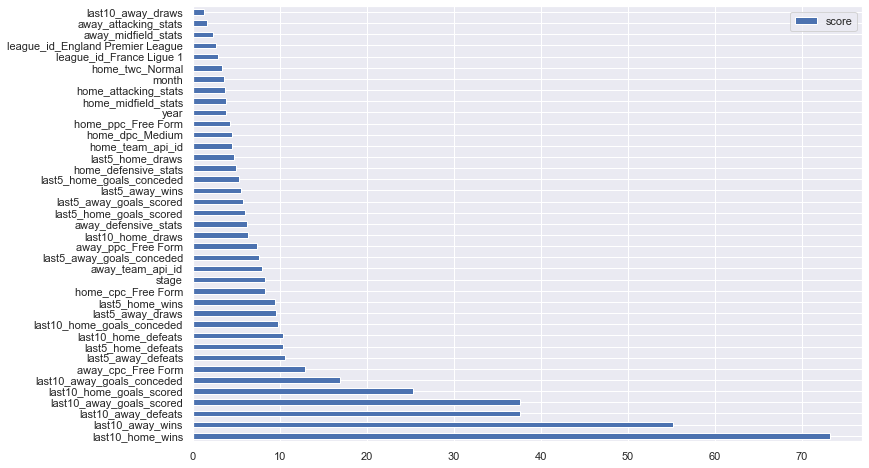

In [949]:
feature_important = model_rf.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(list(final_df)), columns="score").plot(kind='barh', figsize = (12,8));

In [950]:
from sklearn.metrics import classification_report

y_pred = model_rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.49      0.89      0.63      2358
         1.0       0.50      0.31      0.38      1512
         2.0       0.00      0.00      0.00      1326

    accuracy                           0.49      5196
   macro avg       0.33      0.40      0.34      5196
weighted avg       0.37      0.49      0.40      5196



<h3> Perceptron

In [956]:
from sklearn.linear_model import Perceptron

param_grid_percep= {
            'alpha': [np.power(10.,i) for i in range(-6,4)],
            'penalty': ['l1','l2','elasticnet',None],
}

grid_percep = GridSearchCV(Perceptron(early_stopping=True, n_iter_no_change=100, max_iter=1500), param_grid_percep, cv=kfold)

In [957]:
grid_percep.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Perceptron(early_stopping=True, max_iter=1500,
                                  n_iter_no_change=100),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0,
                                   10.0, 100.0, 1000.0],
                         'penalty': ['l1', 'l2', 'elasticnet', None]})

In [958]:
print(grid_percep.best_params_)
model_percep = grid_percep.best_estimator_
from sklearn import  metrics
print("precision_score: {}".format(metrics.precision_score(y_test, model_percep.predict(X_test),average='weighted') ))
print("recall_score: {}".format( metrics.recall_score(y_test, model_percep.predict(X_test),average='weighted') ))
print("f1_score: {}".format( metrics.f1_score(y_test, model_percep.predict(X_test),average='weighted') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model_percep.predict(X_test)) ))

{'alpha': 10.0, 'penalty': 'elasticnet'}
precision_score: 0.20594408205281375
recall_score: 0.45381062355658197
f1_score: 0.2833162431417581
accuracy_score: 0.45381062355658197


In [671]:
##########################################################################################################

In [734]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3> MLPClassifier

In [959]:
from sklearn.neural_network import MLPClassifier

param_grid_mlp= {
    
            # 'alpha': [12,15],
            # 'batch_size': [200],   
            # 'learning_rate_init': [0.0001]

            'alpha': [8,10,12],
            'batch_size': [300,350],   
            'learning_rate_init': [0.0001],
            'activation': ["relu","logistic"]
        
            # 'alpha': [8,10,12],
            # 'batch_size': [300,350],   
            # 'learning_rate_init': [0.0001],
            # 'activation': ["relu","logistic"]
            # 'hidden_layer_sizes': [(100,),(50,50),(50,50,50)]     
            
            # 'alpha': [np.power(10.,i) for i in range(-1,5)],
            # 'batch_size': [300,500],   
            # 'learning_rate_init': [np.power(10.,i) for i in range(-5,-3)]
            #          
            # # 'batch_size': [200,300,500],   
            # 'learning_rate_init': [np.power(10.,i) for i in range(-5,1)]      
}

grid_mlp = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, n_iter_no_change=100 ), param_grid_mlp, cv=kfold)

In [960]:
grid_mlp.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=MLPClassifier(early_stopping=True, max_iter=1000,
                                     n_iter_no_change=100),
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [8, 10, 12], 'batch_size': [300, 350],
                         'learning_rate_init': [0.0001]})

In [964]:
print(grid_mlp.best_params_)
model_mlp = grid_mlp.best_estimator_
from sklearn import  metrics        
print("precision_score: {}".format(metrics.precision_score(y_test, model_mlp.predict(X_test_scaled),average='weighted') ))
print("recall_score: {}".format( metrics.recall_score(y_test, model_mlp.predict(X_test_scaled),average='weighted') ))
print("f1_score: {}".format( metrics.f1_score(y_test, model_mlp.predict(X_test_scaled),average='weighted') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model_mlp.predict(X_test_scaled)) ))

{'activation': 'relu', 'alpha': 8, 'batch_size': 300, 'learning_rate_init': 0.0001}
precision_score: 0.3718802936603277
recall_score: 0.5007698229407236
f1_score: 0.41132562508605647
accuracy_score: 0.5007698229407236


In [965]:
y_pred_mlp = model_mlp.predict(X_test_scaled)
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

         0.0       0.50      0.87      0.64      2358
         1.0       0.49      0.37      0.42      1512
         2.0       0.00      0.00      0.00      1326

    accuracy                           0.50      5196
   macro avg       0.33      0.41      0.35      5196
weighted avg       0.37      0.50      0.41      5196



<h3> SIEĆ NEURONOWA

In [735]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [923]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import History

history0 = History()

model_simplenn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(X_train_nn.shape[1],)),
    
    keras.layers.Dense(150,use_bias=False),
    keras.layers.Dense(100,use_bias=False),

    # keras.layers.Dense(150,use_bias=False),
    # Activation("sigmoid"),
    # keras.layers.Dense(100,use_bias=False),
    # Activation("sigmoid"),

    # keras.layers.Dense(150,use_bias=False),
    # BatchNormalization(),
    # Activation("sigmoid"),
    # Dropout(0.1),
    # keras.layers.Dense(100,use_bias=False),
    # # BatchNormalization(),
    # Activation("sigmoid"),
    # # Dropout(0.3),
    # keras.layers.Dense(40,use_bias=False),

    ###########################################################################
    
    # keras.layers.Dense(100,use_bias=False),
    # BatchNormalization(),
    # Activation("relu"),
    # # Dropout(0.5),
    # keras.layers.Dense(100,use_bias=False),
    # Activation("relu"),

    # keras.layers.Dense(100,use_bias=False),
    # BatchNormalization(),
    # Activation("relu"),
    # Dropout(0.1),
    # keras.layers.Dense(10,use_bias=False),
    # Activation("relu"),

    # keras.layers.Dense(150,use_bias=False),
    # BatchNormalization(),
    # Activation("sigmoid"),
    # Dropout(0.1),
    # keras.layers.Dense(100,use_bias=False),
    # # BatchNormalization(),
    # Activation("sigmoid"),
    # # Dropout(0.3),
    # keras.layers.Dense(40,use_bias=False),

    keras.layers.Dense(3, activation="softmax")
])

model_simplenn.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_56 (Flatten)        (None, 71)                0         
                                                                 
 dense_148 (Dense)           (None, 150)               10650     
                                                                 
 dense_149 (Dense)           (None, 100)               15000     
                                                                 
 dense_150 (Dense)           (None, 3)                 303       
                                                                 
Total params: 25,953
Trainable params: 25,953
Non-trainable params: 0
_________________________________________________________________


In [992]:
model_simplenn.compile(loss="sparse_categorical_crossentropy",optimizer="Adam", metrics=["accuracy"])

callback = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, mode='min', verbose=0)

In [993]:
history0 = model_simplenn.fit(X_train_nn, y_train_nn, validation_data= (X_val_nn, y_val_nn), batch_size=250,epochs=100,callbacks=[callback,early_stopping])

Epoch 1/100
65/67 [============================>.] - ETA: 0s - loss: 1.0095 - accuracy: 0.5012
Epoch 1: saving model to model.h5
67/67 [==============================] - 1s 6ms/step - loss: 1.0093 - accuracy: 0.5016 - val_loss: 1.0052 - val_accuracy: 0.5071
Epoch 2/100
60/67 [=========================>....] - ETA: 0s - loss: 1.0080 - accuracy: 0.5031
Epoch 2: saving model to model.h5
67/67 [==============================] - 0s 4ms/step - loss: 1.0091 - accuracy: 0.5018 - val_loss: 1.0068 - val_accuracy: 0.5071
Epoch 3/100
63/67 [===========================>..] - ETA: 0s - loss: 1.0079 - accuracy: 0.5025
Epoch 3: saving model to model.h5
67/67 [==============================] - 0s 4ms/step - loss: 1.0088 - accuracy: 0.5019 - val_loss: 1.0067 - val_accuracy: 0.5052
Epoch 4/100
62/67 [==========================>...] - ETA: 0s - loss: 1.0088 - accuracy: 0.5018
Epoch 4: saving model to model.h5
67/67 [==============================] - 0s 4ms/step - loss: 1.0089 - accuracy: 0.5023 - val_loss

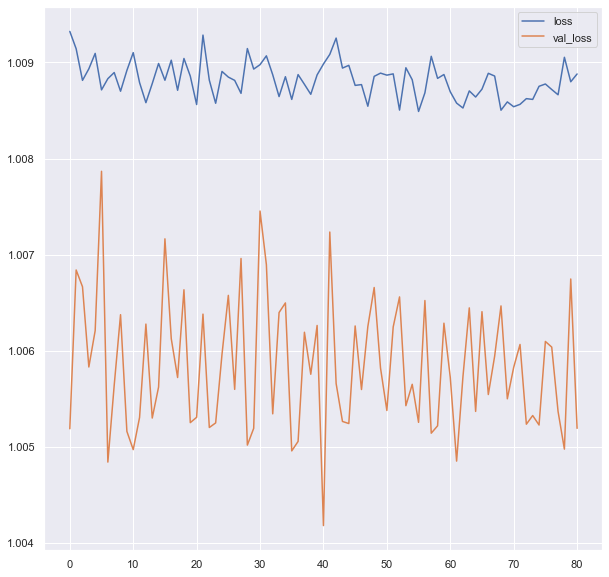

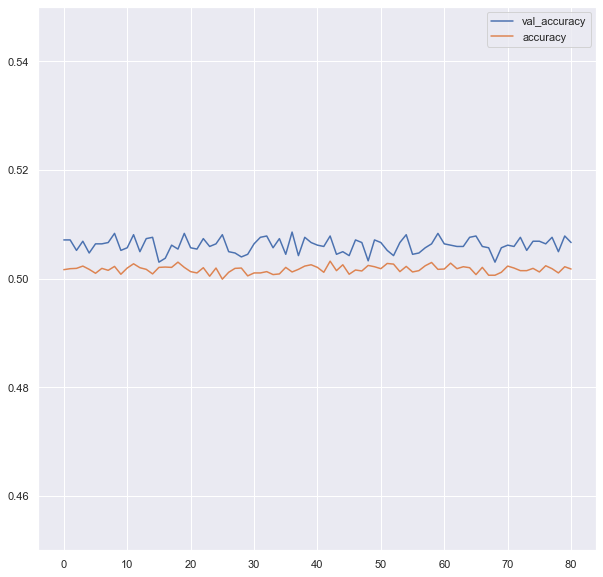

In [994]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history0.history)
plt.figure(figsize=(10,10))
history_df['loss'].plot()
history_df['val_loss'].plot()
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
history_df['val_accuracy'].plot()
history_df['accuracy'].plot()
plt.gca().set_ylim(0.45, 0.55)
plt.grid(True)
plt.legend()
plt.show()

In [1000]:
model_simplenn.evaluate(X_test_scaled, y_test)

163/163 [==============================] - 0s 2ms/step - loss: 1.0124 - accuracy: 0.5023


[1.0123608112335205, 0.5023094415664673]

In [1001]:
from keras.models import load_model

saved_model1 = load_model('w_model_without_act.h5')
saved_model2 = load_model('w_model_with_sigm.h5')
saved_model3 = load_model('w_model_ok.h5')
print(saved_model1.evaluate(X_test_scaled, y_test))
print(saved_model2.evaluate(X_test_scaled, y_test))
print(saved_model3.evaluate(X_test_scaled, y_test))

163/163 [==============================] - 0s 1ms/step - loss: 1.0130 - accuracy: 0.5023
[1.013008952140808, 0.5023094415664673]
163/163 [==============================] - 0s 1ms/step - loss: 1.0131 - accuracy: 0.5008
[1.013069748878479, 0.5007697939872742]
163/163 [==============================] - 0s 1ms/step - loss: 1.0123 - accuracy: 0.5027
[1.0123034715652466, 0.5026943683624268]


In [1002]:
y_pred_snn = np.argmax(model_simplenn.predict(X_test_scaled), axis=-1)
print(classification_report(y_test, y_pred_snn))

              precision    recall  f1-score   support

         0.0       0.51      0.85      0.64      2358
         1.0       0.48      0.39      0.43      1512
         2.0       0.27      0.00      0.00      1326

    accuracy                           0.50      5196
   macro avg       0.42      0.42      0.36      5196
weighted avg       0.44      0.50      0.42      5196



---

<h2>Porównanie wyników

Porównanie (dla najlepszego modelu, czyli tutaj sieci neuronowej), która liga była najlepiej przywidywana

In [1003]:
names = [ 'league_id_Belgium Jupiler League',
 'league_id_England Premier League',
 'league_id_France Ligue 1',
 'league_id_Germany 1. Bundesliga',
 'league_id_Italy Serie A',
 'league_id_Netherlands Eredivisie',
 'league_id_Poland Ekstraklasa',
 'league_id_Portugal Liga ZON Sagres',
 'league_id_Scotland Premier League',
 'league_id_Spain LIGA BBVA',
 'league_id_Switzerland Super League',]

temp_X_test = X_test.copy()
temp_X_test = temp_X_test.reset_index()
temp_X_test.drop(['index'],axis=1)

for name in names:
    print(name.split(sep="_")[2],":")
    indexes = temp_X_test.index[temp_X_test[name] == 1].tolist()
    to_eval = np.array([X_test_scaled[i] for i in indexes])
    saved_model2.evaluate(to_eval, np.array([y_test[i] for i in indexes]))

Belgium Jupiler League :
11/11 [==============================] - 0s 2ms/step - loss: 0.9944 - accuracy: 0.5171
England Premier League :
19/19 [==============================] - 0s 1ms/step - loss: 1.0240 - accuracy: 0.4917
France Ligue 1 :
20/20 [==============================] - 0s 2ms/step - loss: 1.0473 - accuracy: 0.4700
Germany 1. Bundesliga :
16/16 [==============================] - 0s 1ms/step - loss: 1.0109 - accuracy: 0.4980
Italy Serie A :
19/19 [==============================] - 0s 1ms/step - loss: 1.0298 - accuracy: 0.4983
Netherlands Eredivisie :
16/16 [==============================] - 0s 1ms/step - loss: 0.9883 - accuracy: 0.5339
Poland Ekstraklasa :
13/13 [==============================] - 0s 1ms/step - loss: 1.0799 - accuracy: 0.4365
Portugal Liga ZON Sagres :
13/13 [==============================] - 0s 2ms/step - loss: 0.9798 - accuracy: 0.5500
Scotland Premier League :
12/12 [==============================] - 0s 2ms/step - loss: 1.0348 - accuracy: 0.4624
Spain LIGA 

Porównanie wszystkich modeli

163/163 [==============================] - 0s 1ms/step - loss: 1.0130 - accuracy: 0.5023


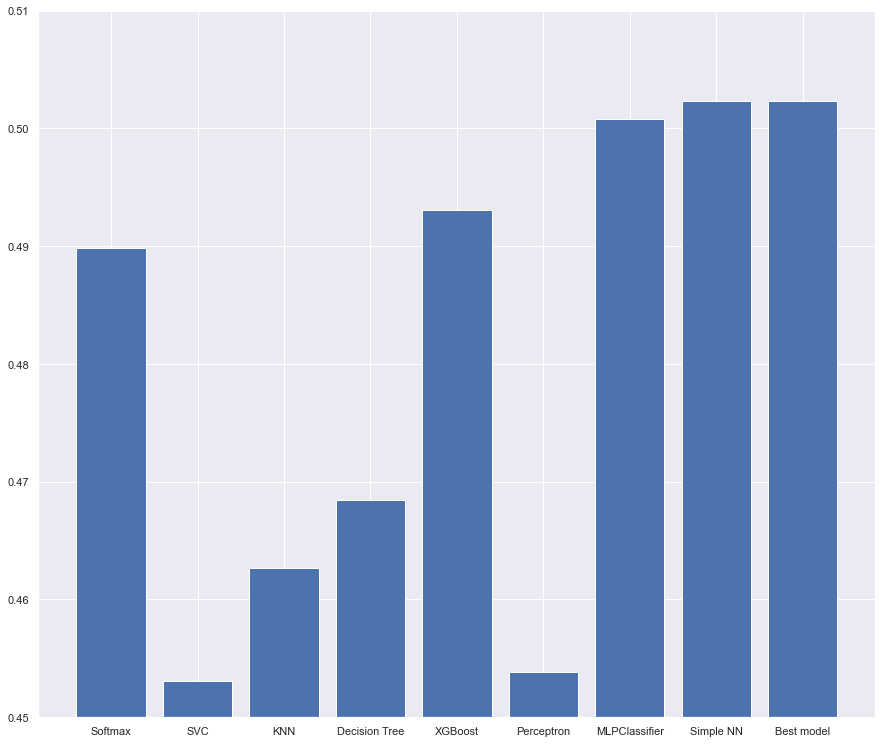

In [1004]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,13))
plt.ylim(0.45,0.51)
models = ['Softmax',
        'SVC', 
        'KNN', 
        'Decision Tree', 
        'XGBoost',
        'Perceptron',
        'MLPClassifier', 
        'Simple NN',
        'Best model']
acc = [
            metrics.accuracy_score(y_test, model_soft.predict(X_test)),
            metrics.accuracy_score(y_test, model_SVC.predict(X_test)),
            metrics.accuracy_score(y_test, model_knn.predict(X_test)),
            metrics.accuracy_score(y_test, model_dtc.predict(X_test)),
            metrics.accuracy_score(y_test, model_rf.predict(X_test)),
            metrics.accuracy_score(y_test, model_percep.predict(X_test)),
            metrics.accuracy_score(y_test, model_mlp.predict(X_test_scaled)),
            model_simplenn.evaluate(X_test_scaled,y_test)[1],
            saved_model1.evaluate(X_test_scaled,y_test)[1]]
plt.bar(models,acc)
plt.show()

 <h2> Podsumowanie

* Patrząc na wykres krzywej uczenia w sieci neuronowej widać, że od pewnego momentu (przy dłuższym uczeniu) nasz model zaczyna overfittować (przy głębszej sieci) i przestaje się uczyć. Przy płytszych model dochodzi do pewnej skuteczności i nie chce jej przekroczyć. Co ciekawe - najlepiej działajacą siecią neuronową na tym zbiorze danych jest sieć neuronowa składająca się z dwóch warstw ukrytych bez funkcji aktywacji. Jeśli jednak zrobimy głębszą sieć - dużo lepiej działa sigmoida jako funkcja aktywacji. Ponadto, nasz zbiór danych lepiej się uczy na sieci o stosunkowo niedużej liczbie neuronów

* Dzięki użyciu "nakładki" na sklearn wydanej przez Intela udało mi się skrócić czas obliczeń niektórych modeli

* Najlepiej działającym płytkim modelem jest XGBoost, co nie powinno być zaskoczeniem, chociaż można zauważyć jego "niecheć" do przewidywania remisów. Nie potrafię powiedzieć z czego to dokładnie wynika, ale na pewno można by poprawić wynik naprawiając tą "niechęć".

* Tak jak można było przypuszczać, po wykresie wag poszczególnych danych wejściowych w XGBoost widać, że forma z ostatnich meczy ma fundamentalne znaczenie na przewidywany wynik

* Najgorzej przewidywanym labelem jest remis

* Najtrudniejszą do przewidzenia ligą jest nasza rodzima Ekstraklasa

* Mając więcej danych, tzn. większą liczbę meczy z większej ilości lig można by z pewnością poprawić znacznie wynik (nawet o 2% lub 3%)

* Podsumowując, nie osiągnałem podczas pracy nad tym zbiorem danych skuteczności jaką mogą się pochwalić bukmacherzy jednakże osiągnąłem wynik ponad 50% co jest lepszym wynik o około 4.5% od prostego zgadywania zwycięzcy.